In [71]:
import pandas as pd
from opencage.geocoder import OpenCageGeocode
import folium
from folium.plugins import FastMarkerCluster
import matplotlib.pyplot as plt

In [72]:
data=pd.read_csv('Data/Merged_Final.csv')

In [73]:
data.head(10)

County Name                        Facility_Name  \
0     HOUSTON     SOUTHEAST ALABAMA MEDICAL CENTER   
1    MARSHALL             MARSHALL MEDICAL CENTERS   
2  LAUDERDALE         NORTH ALABAMA MEDICAL CENTER   
3   JEFFERSON                   ST. VINCENT'S EAST   
4      SHELBY        SHELBY BAPTIST MEDICAL CENTER   
5   JEFFERSON                CALLAHAN EYE HOSPITAL   
6        DALE                  DALE MEDICAL CENTER   
7  MONTGOMERY         BAPTIST MEDICAL CENTER SOUTH   
8  MONTGOMERY        JACKSON HOSPITAL & CLINIC INC   
9         LEE  EAST ALABAMA MEDICAL CENTER AND SNF   

                                        Full_Address State  Total  latitudes  \
0           1108 ROSS CLARK CIRCLE,DOTHAN,HOUSTON,AL    AL   2427  31.215827   
1        2505 U S HIGHWAY 431 NORTH,BOAZ,MARSHALL,AL    AL   5104  34.601233   
2         1701 VETERANS DRIVE,FLORENCE,LAUDERDALE,AL    AL   2120  34.805043   
3  50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,JEFFERSO...    AL  26142  33.564772   
4        1000 FIRST STREET NORTH,ALABASTER,SHELBY,AL    AL  20720  33.075378   
5  1720 UNIVERSITY BLVD, SUITE 500,BIRMINGHAM,JEF...    AL  26142  33.503356   
6                     126 HOSPITAL AVE,OZARK,DALE,AL    AL    541  31.451168   
7  2105 EAST SOUTH BOULEVARD,MONTGOMERY,MONTGOMER...    AL  41558  32.327953   
8          1725 PINE STREET,MONTGOMERY,MONTGOMERY,AL    AL  41558  32.367190   
9              2000 PEPPERELL PARKWAY,OPELIKA,LEE,AL    AL  18884  32.638072   

   longitudes  
0  -85.363433  
1  -87.123343  
2  -87.650814  
3  -86.760155  
4  -86.519100  
5  -86.802349  
6  -85.632062  
7  -86.277782  
8  -86.284783  
9  -85.405403

In [74]:
lats=data['latitudes'].to_list()
lons=data['longitudes'].to_list()

In [237]:
m= folium.Map(
    location=[33.798259,-84.327062],
    zoom_start=4.4,tiles='Stamen Toner')
#FastMarkerCluster(data[['latitudes', 'longitudes']].values.tolist()).add_to(m)
folium.LayerControl().add_to(m)

for row in data.iterrows():
    row=row[1]
    folium.CircleMarker(location=(row["latitudes"],
                                  row["longitudes"]),
                        radius= row['Total']/7500,
                        color="#007849",
                        popup=row['Facility_Name'],
                        fill=False).add_to(m)


# save the map 
#m.save("save_file.html")
    
display(m)


#FastMarkerCluster(data=list(zip(lats,lons))).add_to(m)
#folium.LayerControl().add_to(m)

In [242]:
import plotly.graph_objects as go

data['text'] = data['Facility_Name'] +'Total Cases:'+ data['Total'].astype(str)

fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = data['longitudes'],
        lat = data['latitudes'],
        text = data['text'],
        mode = 'markers',
        marker = dict(
            size = data['Total']/5000,
            opacity = 0.8,
            reversescale=True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Blues',
            cmin = 0,
            color = data['Total'],
            cmax = data['Total'].max(),
            colorbar_title="Total Covid 19 cases<br>count per bounty"
        )))

fig.update_layout(
        title = 'Hospitals location in USA<br>(Hover for Hospital names)',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True
        ),
    )
fig.show()


In [277]:
import random
import numpy as np
import pandas as pd 
import scipy.spatial
from haversine import haversine
def distance(p1,p2):
  return haversine(p1[1:],p2[1:])
def cluster_centroids(data, clusters, k):
  results=[]
  for i in range(k):
    results.append(np.average(data[clusters == i],weights=np.squeeze(np.asarray(data[clusters == i][:,[0]])),axis=0))
  return results
def kmeans(data, k=None, centroids=None, steps=30):
  # Forgy initialization method: choose k data points randomly.
  centroids = data[np.random.choice(np.arange(len(data)), k, False)]
  elbow = []
  for _ in range(max(steps, 1)):
    sqdists = scipy.spatial.distance.cdist(centroids, data, lambda u, v: (distance(u,v)**2))
    elbow.append(sqdists)
    #sse=np.sum((np.mean(elbow)-elbow)**2)
    # Index of the closest centroid to each data point.
    clusters = np.argmin(sqdists, axis=0)
    new_centroids = cluster_centroids(data, clusters, k)
    if np.array_equal(new_centroids, centroids):
      break
    centroids = new_centroids
  
  return clusters, centroids,elbow

In [295]:
vals = data[['Total','latitudes','longitudes']].values
sse=[]
for k in range(1,11):
    clusters,centroids,elbow=kmeans(vals,k)
    sqdist = np.sum((elbow-np.mean(elbow))**2)
    sse.append(sqdist)
sse=sorted(sse,reverse=True)

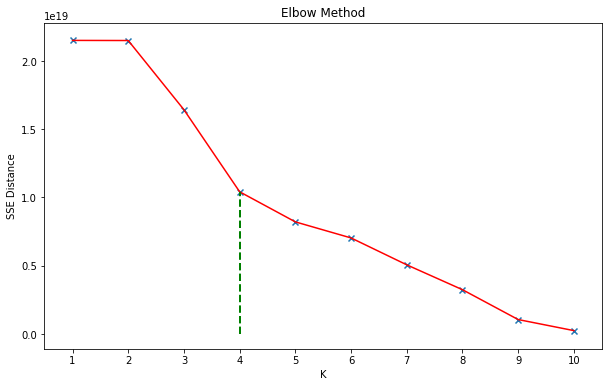

<Figure size 432x288 with 0 Axes>

In [294]:
fig = plt.figure(figsize=(10,6))
x=list(range(1,11))
labels=x
plt.plot(x,sse,'r')
plt.scatter(x,sse,marker='x')
plt.xticks(x, labels)
plt.title('Elbow Method')
plt.xlabel('K')
plt.ylabel('SSE Distance')
plt.plot([4, 4], [0,1.0417261149971132e+19 ],color='green',
         linestyle='dashed',linewidth=2)  # plotting the arbitrary line from point (25,10) to (65,45).    
plt.show()
plt.savefig('elbow.png')

In [269]:
k = 4
random.seed(42)
#run it
clusters,centroids,elbow=kmeans(vals,k)
#output
data['c']=[int(c) for c in clusters]
lats = [centroids[i][1] for i in range(k)]
data['clat'] = data['c'].map(lambda x: lats[x])
longs = [centroids[i][2] for i in range(k)]
data['clong'] = data['c'].map(lambda x: longs[x])
#d['Count']= d.groupby('c')['Facility_Name'].nunique()
data.head()
data

County Name                                     Facility_Name  \
0        HOUSTON                  SOUTHEAST ALABAMA MEDICAL CENTER   
1       MARSHALL                          MARSHALL MEDICAL CENTERS   
2     LAUDERDALE                      NORTH ALABAMA MEDICAL CENTER   
3      JEFFERSON                                ST. VINCENT'S EAST   
4         SHELBY                     SHELBY BAPTIST MEDICAL CENTER   
...          ...                                               ...   
4473       BEXAR               TEXAS CENTER FOR INFECTIOUS DISEASE   
4474     EL PASO                             EL PASO LTAC HOSPTIAL   
4475      TRAVIS  BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVILLE   
4476      HARRIS                              THE HEIGHTS HOSPITAL   
4477       BEXAR                               SOUTHCROSS HOSPITAL   

                                           Full_Address State  Total  \
0              1108 ROSS CLARK CIRCLE,DOTHAN,HOUSTON,AL    AL   2427   
1           2505 U S HIGHWAY 431 NORTH,BOAZ,MARSHALL,AL    AL   5104   
2            1701 VETERANS DRIVE,FLORENCE,LAUDERDALE,AL    AL   2120   
3     50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,JEFFERSO...    AL  26142   
4           1000 FIRST STREET NORTH,ALABASTER,SHELBY,AL    AL  20720   
...                                                 ...   ...    ...   
4473  2303 SE MILITARY DR P O BOX 23340,SAN ANTONIO,...    TX  31316   
4474      1221 N COTTON ST 3RD FLOOR,EL PASO,EL PASO,TX    TX  15373   
4475  2600 EAST  PFLUGERVILLE  PARKWAY,PFLUGERVILLE,...    TX  17646   
4476   1917 ASHLAND STREET, SUITE 300,HOUSTON,HARRIS,TX    TX  56280   
4477  4243 EAST SOUTHCROSS BLVD SUITE 100,SAN ANTONI...    TX  31316   

      latitudes  longitudes  c       clat      clong  \
0     31.215827  -85.363433  3  39.322096 -87.916695   
1     34.601233  -87.123343  3  39.322096 -87.916695   
2     34.805043  -87.650814  3  39.322096 -87.916695   
3     33.564772  -86.760155  3  39.322096 -87.916695   
4     33.075378  -86.519100  3  39.322096 -87.916695   
...         ...         ... ..        ...        ...   
4473  29.352200  -98.456300  1  31.749880 -96.416832   
4474  31.783251 -106.473554  1  31.749880 -96.416832   
4475  30.451519  -97.591347  1  31.749880 -96.416832   
4476  29.803401  -95.404232  1  31.749880 -96.416832   
4477  29.374885  -98.412002  1  31.749880 -96.416832   

                                                   text  
0      SOUTHEAST ALABAMA MEDICAL CENTERTotal Cases:2427  
1              MARSHALL MEDICAL CENTERSTotal Cases:5104  
2          NORTH ALABAMA MEDICAL CENTERTotal Cases:2120  
3                   ST. VINCENT'S EASTTotal Cases:26142  
4        SHELBY BAPTIST MEDICAL CENTERTotal Cases:20720  
...                                                 ...  
4473  TEXAS CENTER FOR INFECTIOUS DISEASETotal Cases...  
4474             EL PASO LTAC HOSPTIALTotal Cases:15373  
4475  BAYLOR SCOTT & WHITE MEDICAL CENTER PFLUGERVIL...  
4476              THE HEIGHTS HOSPITALTotal Cases:56280  
4477               SOUTHCROSS HOSPITALTotal Cases:31316  

[4478 rows x 11 columns]

In [271]:
c_lat=list(set(data['clat']))
c_long=list(set(data['clong']))
centroids=list(zip(c_lat,c_long))

In [273]:
m2 = folium.Map(
    location=[33.798259,-84.327062],
    zoom_start=4.4)
for i in range(len(centroids)):
    folium.CircleMarker(centroids[i]).add_to(m2)
    
folium.LayerControl().add_to(m2)
m2

In [209]:
x1=data['latitudes'].values.tolist()
y1=data['longitudes'].values.tolist()

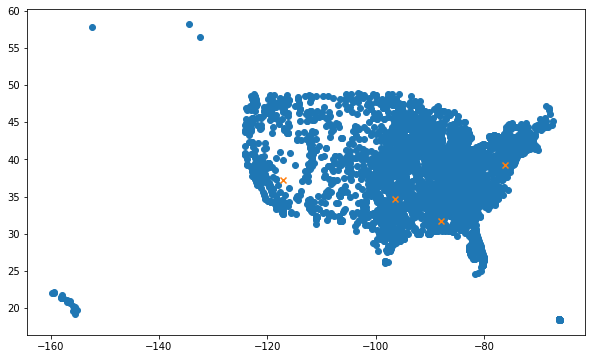

In [296]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(y1,x1)
plt.scatter(c_long,c_lat,marker='x')